# 1.1 - Data Exploration (Info Content)

This notebook provides the in depth analysis on the student performance in exams at public schools.

**Log_Problem.csv**

An exercise is a basic unit for students to learn a certain concept.
There are multiple problems in a single exercise that all relate to a certain concept.

This table records the attempt logs when students try to answer each problem.

The attempt timestamp is rounded to the closest 15-minute interval to reduce privacy concerns.
The uuid and ucid can be used to join the other tables (InfoUserData, InfoContent)

The problem_number refers to the number of problems the user had attempted including this attempt in this exercise.
The exercise_problem_repeat_session refers to the number of times the user encounters this problem in this exercise.

We define the answer to be correct when the user answered the correct answer the first time and does not use any hints.
There are hints that the student can use that provides a step-by-step guide to get the correct answer.
Each time a student uses a hint, a step of the step-by-step guide is shown.

The Proficiency Mechanism
According to the forgetting curve proposed by psychologist Hermann Ebbinghaus, by doing spaced repetition review in learning, we can improve the memory of the newly learned concepts and knowledge.

To achieve this, Junyi Academy used the "Proficiency Mechanism" to encourage students to come back and review at regular intervals.
The "Proficiency Mechanism" allows students to convert short-term memory into long-term memory through appropriate and repeated review.

There are five possible levels, all users start from level 0 and progress to level 4 which we considered Proficient for that exercise.

To reach level 1, the user will have to answer the problems correctly 5 times in the recent 6 problems attempts in the exercise.

After reaching level 1, the user is required to wait 6 hours before he/she is able to attempt to level up again to level 2.

After the waiting, the user will answer 2 problems from the exercise. For example, the user is at level 2 and get a chance to answer 2 problems:

- If both are correct, the user is upgraded to level 3.
- If both are incorrect, the user is downgraded to level 1.
- If one of them is correct and one of them is incorrect, the level is unchanged and the user is prompted to try again the challenge.

The procedure to upgrade or downgrade is the same for the other levels. But users will not be downgraded at level 1 or when the user reaches level 4 Proficient.

After reaching level 2, the user is required to wait 16 hours before he/she is able to attempt to level up again to level 3.

After reaching level 3, the user is required to wait 40 hours before he/she is able to attempt to level up again to level 4, which is the final level and considered Proficient for that exercise.

| Variable Name | Description |
|:-|:-|
| timestamp_TW | The timestamp of the first behavior, answered the problem or used a hint. It is in UTC+8 timezone and rounded to the closest 15 mins interval to preserve privacy. |
| uuid | The unique ID of the user. It can be used to join with Info_UserData. |
| ucid | The unique ID of the content. It can be used to join with Info_Content. |
| upid | The unique ID of the problem. |
| problem_number | The number of problems this user had encountered, including this problem, in this exercise. |
| exercise_problem_repeat_session | The number of times the user encounters this problem in this exercise |
| is_correct | Whether the answer is considered correct or not. Only if the student answered the correct answer for the first time will it be `TRUE`. If the student used a hint or answered the wrong answer for the first time, it will be `FALSE`. |
| total_sec_taken | How many seconds the user use for this problem encounter |
| total_attempt_cnt | How many times have the user submitted an answer for this problem encounter |
| used_hint_cnt | How many hints the user have used for this problem encounter |
| is_hint_used | Whether the user use a hint or not. |
| is_downgrade | After this attempt, is the user upgraded to the next level? Please refer to the detailed data description for the Proficiency Mechanism. |
| is_upgrade | After this attempt, is the user downgraded to the next level? Please refer to the detailed data description for the Proficiency Mechanism. |
| level | After this attempt, which level does this user belong to in this exercise? There are five possible levels. All users start from level 0 and declare Proficient at level 4. Please refer to the detailed data description for the Proficiency Mechanism. |

## Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='whitegrid')
sns.set_color_codes('pastel')

## Loading Data

In [3]:
%%time
log_problem_raw_df = pd.read_csv('../data/raw/Log_Problem.csv', index_col='upid')

Wall time: 11.7 s


In [4]:
log_problem_raw_df.head()

,timestamp_TW,uuid,ucid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
upid,,,,,,,,,,,,,
ZmKEZ0F2WFqhlL7KFfJcHEnZCZu0e4p+CVG5rSlyKYk=,2018-09-28 20:00:00 UTC,Kpq2q+eKw/O+6/jLs3XJosgmI7weEJxJZdnkKTbbF8I=,Ps4dfShfpeMF3VG030HqZ2bsbD7PaVxvJYFTtroeSzQ=,2,1,True,11,1,0,False,NaN,NaN,0
tO9dyvadKWMVQgEx/BXtRIYJ2TRJFQgwvcsBwFb4+xI=,2018-09-28 10:15:00 UTC,0+VU/Zb0Q96uoByuRhl7r9bJuJO6CKWpsmNMEuijSzc=,/d39FzqaM3PZzpoMXxA80PMICsVhzfL6MGSCqZtsQOo=,6,1,True,26,1,0,False,NaN,NaN,0
6Lxz6aXvgyw3vZd3v8g6jgoCRDPOQzVPx/dnEC0o7DQ=,2018-09-05 20:00:00 UTC,g8DnYvIqpolw10XlwWeIWv6NbDPByUbmgH8EshJqBns=,YuGOmB+frbM8rfAa0RJE882R+IoMf9N89OiVqLbAHBw=,4,1,True,78,1,0,False,NaN,NaN,0
1fIjdakTApQp5PfWog87uOmM6JuoNE/oQq2y5/fMmfw=,2018-09-14 16:30:00 UTC,kSyUTFlepsYUD723IPL/jEZ520xaKbscrBmNtBUFR1o=,BG1RsWojzEHzV28RBm/1iKi1NyZgDcDomLYEJSV6lmo=,3,1,True,7,1,0,False,NaN,NaN,0
8V/NT6M+er2I3V3ZIWRNo4Qbo3Iad89PHbeeZeoZeF0=,2018-09-13 16:00:00 UTC,XMFbFA7C49+LRhUddhelfPpA6F5dbOoxeyL3eYbuTlY=,qPHR8aBqOhKij9IS/Y8IR8prwWruoDBGU1tVUhXDJkE=,12,1,True,48,1,0,False,False,True,1


Let’s have a look at data dimensionality, feature names, and feature types.

In [5]:
log_problem_raw_df.shape

(4273203, 13)

From the output, we can see that the table contains 1330 rows and 9 columns.

Now let's try printing out column names using columns:

In [6]:
log_problem_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4273203 entries, ZmKEZ0F2WFqhlL7KFfJcHEnZCZu0e4p+CVG5rSlyKYk= to boVeJmNRnhK2ErAZZ1dNhsQ4uNUTCenC8IIvEdl9XSA=
Data columns (total 13 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   timestamp_TW                     object
 1   uuid                             object
 2   ucid                             object
 3   problem_number                   int64 
 4   exercise_problem_repeat_session  int64 
 5   is_correct                       bool  
 6   total_sec_taken                  int64 
 7   total_attempt_cnt                int64 
 8   used_hint_cnt                    int64 
 9   is_hint_used                     bool  
 10  is_downgrade                     object
 11  is_upgrade                       object
 12  level                            int64 
dtypes: bool(2), int64(6), object(5)
memory usage: 399.4+ MB


Object, int64 and bool are the data types of our features. From the information above, it also provide the information to see if there are any missing values. Here, there are none because each column contains 1330 observations, the same number of rows we saw before with shape. The dataframe is very large.

In [7]:
log_problem_raw_df.describe()

,problem_number,exercise_problem_repeat_session,total_sec_taken,total_attempt_cnt,used_hint_cnt,level
count,4.273203e+06,4.273203e+06,4.273203e+06,4.273203e+06,4.273203e+06,4.273203e+06
mean,9.742269e+00,1.230760e+00,4.483628e+01,1.682750e+00,6.109738e-01,4.226864e-01
std,1.495265e+01,8.339222e-01,9.534864e+01,2.790979e+00,1.184235e+00,8.581086e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,1.000000e+00,2.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.100000e+01,1.000000e+00,4.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00
max,6.250000e+02,4.700000e+01,1.800000e+03,7.980000e+02,1.300000e+01,4.000000e+00


- timestamp_TW - The datatype is not correct **(Parsing needed)**
- problem_number - The number of problems this user had encountered, including this problem, in this exercise.
- exercise_problem_repeat_session - The number of times the user encounters this problem in this exercise.
- is_correct - The answer is correct or not. **(Ready)**
- total_sec_taken - Total time taken. **(Ready)**
- total_attempt_cnt - Total attempt
- used_hint_cnt
- is_hint_used 
- is_downgrade - **(Cleaning needed)**
- is_upgrade - **(Cleaning needed)**
- level - Level (0, 1, 2, 3, 4) Variable that will be the target variable. **(Target variable)**

### Categorical Var

For categorical (type object) feature we can use the value_counts method. Let's have a look at the distribution of Churn:

In [11]:
log_problem_raw_df.groupby(by=['uuid','ucid'])['level'].max().reset_index()

,uuid,ucid,level
0,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,Qx6mwirYKln7CTvOXad5Do5OkVKmypYSQfFs0MB6Cvs=,1
1,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,eJs/Pql/Xui+9mjL0q4CwHI/r+w6Bn3tTCt0i6r4xrg=,0
2,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,hxF+GCZ2kFjuoHOUVj0a6Jn9NbRfydExscjLa0cvxuw=,0
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,m7rxdmifsJ8HxB91x1USFvW7op/ZusrvlAjq/FAmRE8=,0
4,++KRUQaY4gFsmV7egJVOWqbqbTth/oJBB7yX1HvCSL4=,BG1RsWojzEHzV28RBm/1iKi1NyZgDcDomLYEJSV6lmo=,1
...,...,...,...
489033,zzvvUOwcSXXTXd8xoyimNcm2DjeVPLmZAI19WKfhSAM=,hv7kHCAIdj7thZUmlqz553leG5bFNYgzXmLfB5m4Xvw=,1
489034,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,4p305X/NqL1Zx9j6BDJEpiQx090kFF3o/LTTGJt5s/E=,1
489035,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,9OXYxjWigzS5FgP5nZ1y1EAtwQihC19PGhDlRKqK3Pg=,1
489036,zzyukk9LNl7j/9xxgZj6roQBbGn1MjSPTCgc0r5sXpU=,EeAQRS+kGarrxqFWxO5U2lJ12zE7xgtIiHO9ojBNYpw=,1


In [31]:
content_level_distribution = log_problem_raw_df.groupby(by=['uuid','ucid'])['level'].max().reset_index()['level']
content_level_distribution

0         1
1         0
2         0
3         0
4         1
         ..
489033    1
489034    1
489035    1
489036    1
489037    1
Name: level, Length: 489038, dtype: int64

Text(0.5, 1.0, 'content level distribution')

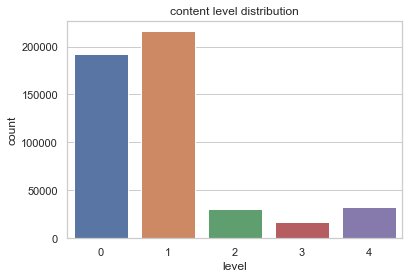

In [30]:
sns.countplot(content_level_distribution).set_title('content level distribution')

In [20]:
log_problem_raw_df['level'].value_counts()

0    3188853
1     634546
2     235695
3     156147
4      57962
Name: level, dtype: int64

Text(0.5, 1.0, 'level distribution')

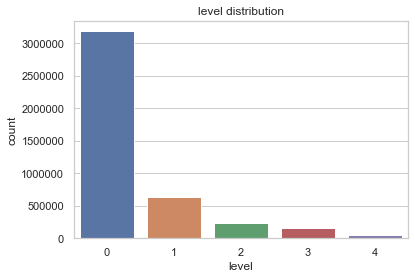

In [21]:
sns.countplot(log_problem_raw_df['level']).set_title('level distribution')

### uuid

In [22]:
sns.barplot(log_problem_raw_df['uuid'], log_problem_raw_df['level'])

KeyboardInterrupt: 

In [ ]:
log_problem_raw_df.groupby('')

In [ ]:
df = (pd.to_datetime(log_problem_raw_df['timestamp_TW'], format='%Y-%m-%d %H:%M:%S %Z')
        .dt.floor('d')
        .value_counts()
        .rename_axis('date')
        .reset_index(name='count'))
        .sort_values('date')
print (df)

In [ ]:
df.sort_values('date')

In [25]:
log_problem_raw_df.head()

,timestamp_TW,uuid,ucid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
upid,,,,,,,,,,,,,
ZmKEZ0F2WFqhlL7KFfJcHEnZCZu0e4p+CVG5rSlyKYk=,2018-09-28 20:00:00 UTC,Kpq2q+eKw/O+6/jLs3XJosgmI7weEJxJZdnkKTbbF8I=,Ps4dfShfpeMF3VG030HqZ2bsbD7PaVxvJYFTtroeSzQ=,2,1,True,11,1,0,False,NaN,NaN,0
tO9dyvadKWMVQgEx/BXtRIYJ2TRJFQgwvcsBwFb4+xI=,2018-09-28 10:15:00 UTC,0+VU/Zb0Q96uoByuRhl7r9bJuJO6CKWpsmNMEuijSzc=,/d39FzqaM3PZzpoMXxA80PMICsVhzfL6MGSCqZtsQOo=,6,1,True,26,1,0,False,NaN,NaN,0
6Lxz6aXvgyw3vZd3v8g6jgoCRDPOQzVPx/dnEC0o7DQ=,2018-09-05 20:00:00 UTC,g8DnYvIqpolw10XlwWeIWv6NbDPByUbmgH8EshJqBns=,YuGOmB+frbM8rfAa0RJE882R+IoMf9N89OiVqLbAHBw=,4,1,True,78,1,0,False,NaN,NaN,0
1fIjdakTApQp5PfWog87uOmM6JuoNE/oQq2y5/fMmfw=,2018-09-14 16:30:00 UTC,kSyUTFlepsYUD723IPL/jEZ520xaKbscrBmNtBUFR1o=,BG1RsWojzEHzV28RBm/1iKi1NyZgDcDomLYEJSV6lmo=,3,1,True,7,1,0,False,NaN,NaN,0
8V/NT6M+er2I3V3ZIWRNo4Qbo3Iad89PHbeeZeoZeF0=,2018-09-13 16:00:00 UTC,XMFbFA7C49+LRhUddhelfPpA6F5dbOoxeyL3eYbuTlY=,qPHR8aBqOhKij9IS/Y8IR8prwWruoDBGU1tVUhXDJkE=,12,1,True,48,1,0,False,False,True,1


In [32]:
x = pd.pivot_table(log_problem_raw_df, index=['ucid','uuid'],
                       values=['level'], aggfunc=max).sort_values('level').reset_index()
x

,ucid,uuid,level
0,+DlgHAr1GtoQgtGqwoen6pt4/ayVRO+rMaCVZ7jGCHE=,+MtbzFl3O0WROLDzEefuYsq5Xe5xB94+AMb4aLFOb+Q=,0
1,XG1pV3YZ4tnQkmvmVbwNYnm01m9sRhZovPW1qTPIGYI=,9XM8KFmVB5j0j7/7ZEi8HVgchzkZgEKRVOt8x/1jTjc=,0
2,XG1pV3YZ4tnQkmvmVbwNYnm01m9sRhZovPW1qTPIGYI=,9dGmWm5zhI1MJHJNbQDRSBI0oQjecTnDUDEtLLul0rY=,0
3,XG1pV3YZ4tnQkmvmVbwNYnm01m9sRhZovPW1qTPIGYI=,9sgXDvFr56LFRVeYbDUrpoVwXXSk03L4+AN9ixET6Vg=,0
4,XG1pV3YZ4tnQkmvmVbwNYnm01m9sRhZovPW1qTPIGYI=,9tZQh0aeuiWmTGlSLDrxQhSPHYXQlrI9YBmzQsFe12c=,0
...,...,...,...
489033,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,0ccQa7KxRAH1ZZwmLO5n1um5JEiRQAGK1ndx1gY3TlQ=,4
489034,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,0ckuNPv4VdrP0U59qty4MKWSnI0XR8wPxtrP+Uq6OO0=,4
489035,5J5VC2w6tQ7Fcg+P2oh3vM6Bo2l8bWGb6mdInIicams=,VrWRgYSbuPfHl1MhfKww9MQsqPCHeAN0GkcxjejjziU=,4
489036,vhz7ZImgcFLciakjMFdmn0S/He85wqQkhLiYXRPpu18=,SAbPLpfSLx6l3eIIfgrJfjOKQUHH4iFP6FglDg4KX7w=,4


In [34]:
pd.pivot_table(x, index=['ucid'], values=['level'], aggfunc=np.mean).sort_values('level')

,level
ucid,
3bHs8ubahqHEEoAqR+v3jiUd36aEtg6AwQwevvoB5g0=,0.000000
ZiB8YudXZGaYEDJxnFGFKxDYg7p21KMyv2iISc6REEQ=,0.000000
wWxHJ8aDeAVSEp62k6aRXGwVOAzzQz+w7iBA9wZium4=,0.000000
ivMwj8BftiUhzy+S92MtpdbXyuTfab9H8lSFFi2azt4=,0.000000
4OOqY/SxnrDhJYNG9IWfI75NGmUwzQF9qC7YYdUwrbI=,0.000000
...,...
dp0m1kS6Bygoksx9S/gkBqTcWPoglbf1HT3Ma3U3N8U=,1.738001
yC0fMjNE4oQ+f9qyqRKdEydTAIscFvSra9wP052SgL4=,2.000000
dEdTB/d9fVuyj1/b7hO9H4lL6XcWJW155+5nwHCyE7w=,2.000000


In [36]:
log_problem_raw_df.head()

,timestamp_TW,uuid,ucid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
upid,,,,,,,,,,,,,
ZmKEZ0F2WFqhlL7KFfJcHEnZCZu0e4p+CVG5rSlyKYk=,2018-09-28 20:00:00 UTC,Kpq2q+eKw/O+6/jLs3XJosgmI7weEJxJZdnkKTbbF8I=,Ps4dfShfpeMF3VG030HqZ2bsbD7PaVxvJYFTtroeSzQ=,2,1,True,11,1,0,False,NaN,NaN,0
tO9dyvadKWMVQgEx/BXtRIYJ2TRJFQgwvcsBwFb4+xI=,2018-09-28 10:15:00 UTC,0+VU/Zb0Q96uoByuRhl7r9bJuJO6CKWpsmNMEuijSzc=,/d39FzqaM3PZzpoMXxA80PMICsVhzfL6MGSCqZtsQOo=,6,1,True,26,1,0,False,NaN,NaN,0
6Lxz6aXvgyw3vZd3v8g6jgoCRDPOQzVPx/dnEC0o7DQ=,2018-09-05 20:00:00 UTC,g8DnYvIqpolw10XlwWeIWv6NbDPByUbmgH8EshJqBns=,YuGOmB+frbM8rfAa0RJE882R+IoMf9N89OiVqLbAHBw=,4,1,True,78,1,0,False,NaN,NaN,0
1fIjdakTApQp5PfWog87uOmM6JuoNE/oQq2y5/fMmfw=,2018-09-14 16:30:00 UTC,kSyUTFlepsYUD723IPL/jEZ520xaKbscrBmNtBUFR1o=,BG1RsWojzEHzV28RBm/1iKi1NyZgDcDomLYEJSV6lmo=,3,1,True,7,1,0,False,NaN,NaN,0
8V/NT6M+er2I3V3ZIWRNo4Qbo3Iad89PHbeeZeoZeF0=,2018-09-13 16:00:00 UTC,XMFbFA7C49+LRhUddhelfPpA6F5dbOoxeyL3eYbuTlY=,qPHR8aBqOhKij9IS/Y8IR8prwWruoDBGU1tVUhXDJkE=,12,1,True,48,1,0,False,False,True,1


In [37]:
x = pd.pivot_table(log_problem_raw_df, index=['uuid','ucid'],
                       values=['level'], aggfunc=max).sort_values('level').reset_index()
x

,uuid,ucid,level
0,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,gOX2LgERQWRqT9yOkaWwpJsbIezSaFgRg27NSNXzrjs=,0
1,GEQ3Xja/xkEfJdcGWqWJY3pB9PdAcg4bDPyoUK1YQ5c=,YK8k7vXBGE+Uz9zSJyxXp6OC214bTKKGGTqalD/Zf5I=,0
2,mpkcV1e3TkvueqaOWgoclN0uXYN/CwDmPR5k2Jyikdo=,qAtLSVC787ORvbDSF5uaZalBGtpHCkGfy0rXm8xJD/I=,0
3,T5Y4rswhsP14gzKBs0ZGdYOg/JfI4NESERKPn9hlXzQ=,o/g95+OW/vglmMGwH72w/A/K5Gc6TB/BDAHowBQDjGQ=,0
4,GEQ3Xja/xkEfJdcGWqWJY3pB9PdAcg4bDPyoUK1YQ5c=,i63OzZpTkqfe5ND+D9DAeVXqzKrB/7OasjU2PnkdHfs=,0
...,...,...,...
489033,vJf+gt4wXrNyMuo+QZO15cNOLLiI+rtvNHIX3jGVf4k=,tPzc0JSXpr0JmIZKsEwoPNd7HYlbgErDMf2uJUXKJco=,4
489034,vJf+gt4wXrNyMuo+QZO15cNOLLiI+rtvNHIX3jGVf4k=,zcH7Yl/gFwkU2Mej9UzQgaJL66wIdiMucPZwVyeqHxc=,4
489035,gTQTS+bu8HrI3YxXl8bN6/kzVFe3nDzjidGgrd85QZw=,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,4
489036,vJf+gt4wXrNyMuo+QZO15cNOLLiI+rtvNHIX3jGVf4k=,clP2+ai8jg0m7J92YX2RrRzXyBa4jLyja5WruzDuOZ0=,4


In [38]:
x[x['uuid']=='mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M='] 

,uuid,ucid,level
0,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,gOX2LgERQWRqT9yOkaWwpJsbIezSaFgRg27NSNXzrjs=,0
5567,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,IxasEWID5fnM7sM/cwJQXizkkLLKkLjqUftm4hy6264=,0
5568,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,Is6C9Z4P5w/BKBc3H9gl2cC0EFpEQD5dKLQomh0Wv1w=,0
5569,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,Iq4bn747ApUwO7SvDR8vvfjBWGvDxAyBTsce0dN3Q1w=,0
5570,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,IjjEW09De8UieuEGOrK9rwUBobUbJgcphwsteZNFJcA=,0
5571,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,FJV9jFDQLQAIAZoc7YboSSkQOkS3dNtCQAVDL874AKM=,0
5575,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,M8Lfw5taHmpTdDkfSEoNpd9/xmXC2wRXO6O0Bs4qOIw=,0
5587,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,V00R/cPz9t+/NMeNSgfvISuDZkhuHZZh3/hADlbJmW4=,0
5588,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,WkBETrljVP4CWMKsouy8P5j94DMpD1mdMxCCZ7ftnN0=,0
5589,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,WnROIwtQSSRuDI+N9zspe70i0h/BVJUxoil4KIbnP6M=,0


In [41]:
test = x[x['uuid']=='mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M='] 

In [42]:
test

,uuid,ucid,level
0,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,gOX2LgERQWRqT9yOkaWwpJsbIezSaFgRg27NSNXzrjs=,0
5567,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,IxasEWID5fnM7sM/cwJQXizkkLLKkLjqUftm4hy6264=,0
5568,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,Is6C9Z4P5w/BKBc3H9gl2cC0EFpEQD5dKLQomh0Wv1w=,0
5569,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,Iq4bn747ApUwO7SvDR8vvfjBWGvDxAyBTsce0dN3Q1w=,0
5570,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,IjjEW09De8UieuEGOrK9rwUBobUbJgcphwsteZNFJcA=,0
5571,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,FJV9jFDQLQAIAZoc7YboSSkQOkS3dNtCQAVDL874AKM=,0
5575,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,M8Lfw5taHmpTdDkfSEoNpd9/xmXC2wRXO6O0Bs4qOIw=,0
5587,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,V00R/cPz9t+/NMeNSgfvISuDZkhuHZZh3/hADlbJmW4=,0
5588,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,WkBETrljVP4CWMKsouy8P5j94DMpD1mdMxCCZ7ftnN0=,0
5589,mXz+LIWNyyokZMp8A2F8Rs7W/ZOwQZD2Unr4PkQJb/M=,WnROIwtQSSRuDI+N9zspe70i0h/BVJUxoil4KIbnP6M=,0


In [ ]:
test['next_ucid'] = test[]

In [49]:
for i in range(0, len(test)):
    test.next_ucid.values[i] = test.ucid.values[i-1]


AttributeError: 'DataFrame' object has no attribute 'next_ucid'

In [46]:
test.ucid.values[0]

'gOX2LgERQWRqT9yOkaWwpJsbIezSaFgRg27NSNXzrjs='